<a href="https://colab.research.google.com/github/Atrib99/Python_Projects/blob/master/BTC_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install yfinance
!pip install mplfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from time import time
import datetime
import warnings
import mplfinance as mpf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.7 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
#import the data...BTC
tickerSymbol = "BTC-USD"
data = yf.Ticker(tickerSymbol)
data

end_date = datetime.date.today()
start_date = end_date-datetime.timedelta(days=365)
tomorrow = end_date+datetime.timedelta(days=1)
prices = data.history(start=start_date,end=end_date).Close
prices

Date
2023-02-18 00:00:00+00:00    24641.277344
2023-02-19 00:00:00+00:00    24327.642578
2023-02-20 00:00:00+00:00    24829.148438
2023-02-21 00:00:00+00:00    24436.353516
2023-02-22 00:00:00+00:00    24188.843750
                                 ...     
2024-02-12 00:00:00+00:00    49958.222656
2024-02-13 00:00:00+00:00    49742.441406
2024-02-14 00:00:00+00:00    51826.695312
2024-02-15 00:00:00+00:00    51938.554688
2024-02-16 00:00:00+00:00    52160.203125
Name: Close, Length: 364, dtype: float64

In [3]:
#Calculate Returns
returns = prices.pct_change().dropna()
returns

Date
2023-02-19 00:00:00+00:00   -0.012728
2023-02-20 00:00:00+00:00    0.020615
2023-02-21 00:00:00+00:00   -0.015820
2023-02-22 00:00:00+00:00   -0.010129
2023-02-23 00:00:00+00:00   -0.009978
                               ...   
2024-02-12 00:00:00+00:00    0.034462
2024-02-13 00:00:00+00:00   -0.004319
2024-02-14 00:00:00+00:00    0.041901
2024-02-15 00:00:00+00:00    0.002158
2024-02-16 00:00:00+00:00    0.004268
Name: Close, Length: 363, dtype: float64

[*********************100%%**********************]  1 of 1 completed


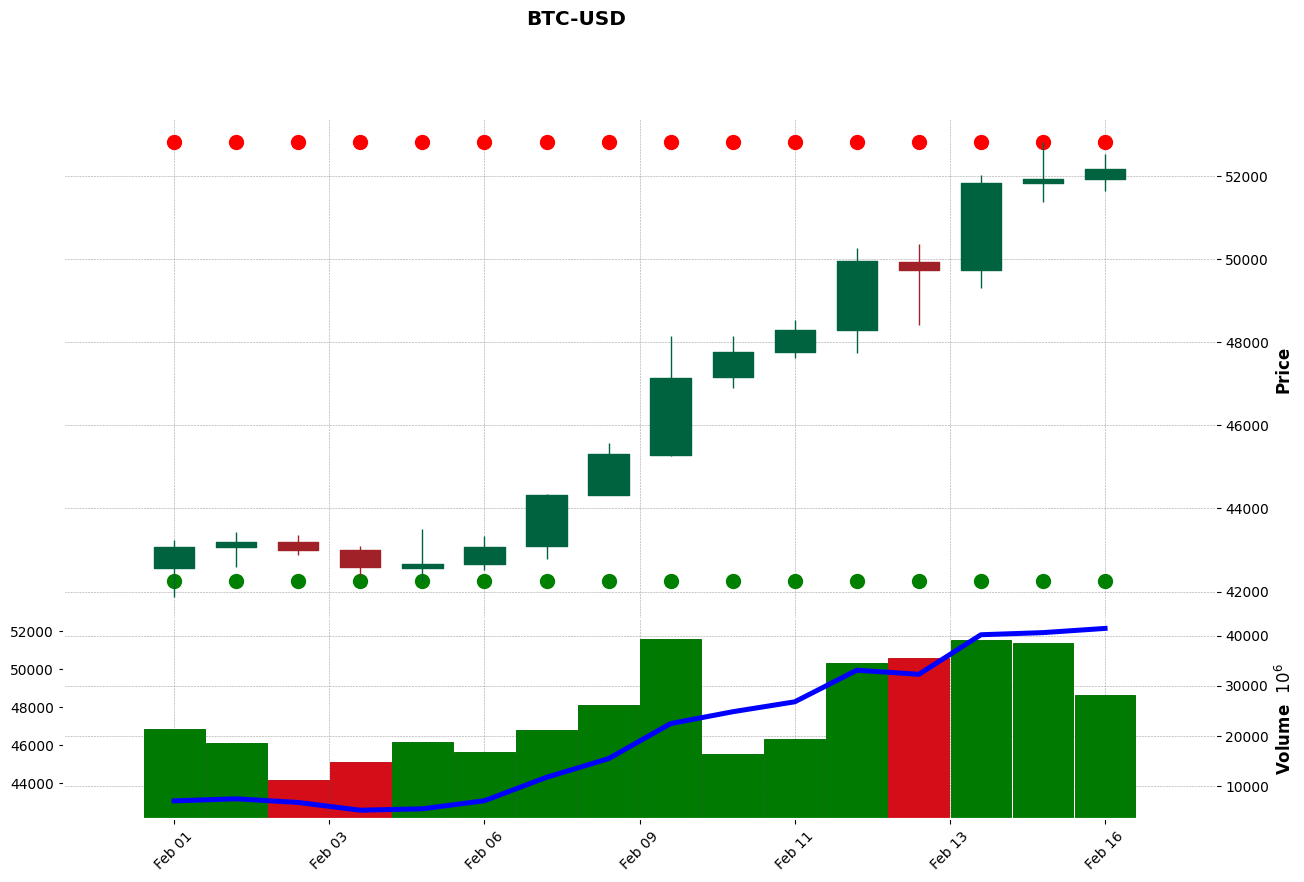

In [18]:
def get_support_resistance(data):
    """
    Calculate support and resistance levels.
    """
    # Calculate local minima and maxima
    minima_idx = np.where((data['Low'].shift(1) > data['Low']) & (data['Low'].shift(-1) > data['Low']))[0]
    maxima_idx = np.where((data['High'].shift(1) < data['High']) & (data['High'].shift(-1) < data['High']))[0]

    # Find the lowest low and highest high within the specified window
    window = 20
    support = data.iloc[minima_idx[-window:]]['Low'].min()
    resistance = data.iloc[maxima_idx[-window:]]['High'].max()

    return support, resistance

# Get historical data for a stock
ticker = 'BTC-USD'  # Ticker symbol for BTC
data = yf.download(ticker, start='2024-02-01', end='2024-02-17')

# Calculate support and resistance levels
support, resistance = get_support_resistance(data)
# Create arrays of the same length as the data with support and resistance levels
support_array = np.full(len(data), support)
resistance_array = np.full(len(data), resistance)

# Plot candlestick chart with support and resistance levels
mpf.plot(data, type='candle', style='charles', title=ticker, ylabel='Price', volume=True,
         addplot=[mpf.make_addplot(data['Close'], color='b', panel=1),
                  mpf.make_addplot(support_array, scatter=True, markersize=100, marker='o', color='g'),
                  mpf.make_addplot(resistance_array, scatter=True, markersize=100, marker='o', color='r')],
         figratio=(16, 8), figsize=(16, 10))




In [6]:
#Building the model of ARIMA
model = ARIMA(prices,order = (7,0,6))
fitted = model.fit()
print(fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Che

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  364
Model:                 ARIMA(7, 0, 6)   Log Likelihood               -2919.589
Date:                Sun, 18 Feb 2024   AIC                           5869.177
Time:                        04:29:47   BIC                           5927.635
Sample:                    02-18-2023   HQIC                          5892.411
                         - 02-16-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.185e+04    934.330     34.087      0.000       3e+04    3.37e+04
ar.L1         -0.2935      0.089     -3.297      0.001      -0.468      -0.119
ar.L2         -0.6555      0.085     -7.674      0.0

In [15]:
#Prediction for the next 100 days
next_day_price = fitted.forecast(20, alpha=0.05)
print(next_day_price)


2024-02-17 00:00:00+00:00    52154.018559
2024-02-18 00:00:00+00:00    52064.319953
2024-02-19 00:00:00+00:00    52069.251655
2024-02-20 00:00:00+00:00    52172.506779
2024-02-21 00:00:00+00:00    52302.222261
2024-02-22 00:00:00+00:00    52215.184434
2024-02-23 00:00:00+00:00    51956.119052
2024-02-24 00:00:00+00:00    52078.915215
2024-02-25 00:00:00+00:00    52187.821453
2024-02-26 00:00:00+00:00    52159.010440
2024-02-27 00:00:00+00:00    52195.916289
2024-02-28 00:00:00+00:00    52119.062893
2024-02-29 00:00:00+00:00    52045.084646
2024-03-01 00:00:00+00:00    52018.148779
2024-03-02 00:00:00+00:00    52173.050511
2024-03-03 00:00:00+00:00    52246.200423
2024-03-04 00:00:00+00:00    52055.033405
2024-03-05 00:00:00+00:00    52049.645322
2024-03-06 00:00:00+00:00    52075.695955
2024-03-07 00:00:00+00:00    52072.006822
Freq: D, Name: predicted_mean, dtype: float64


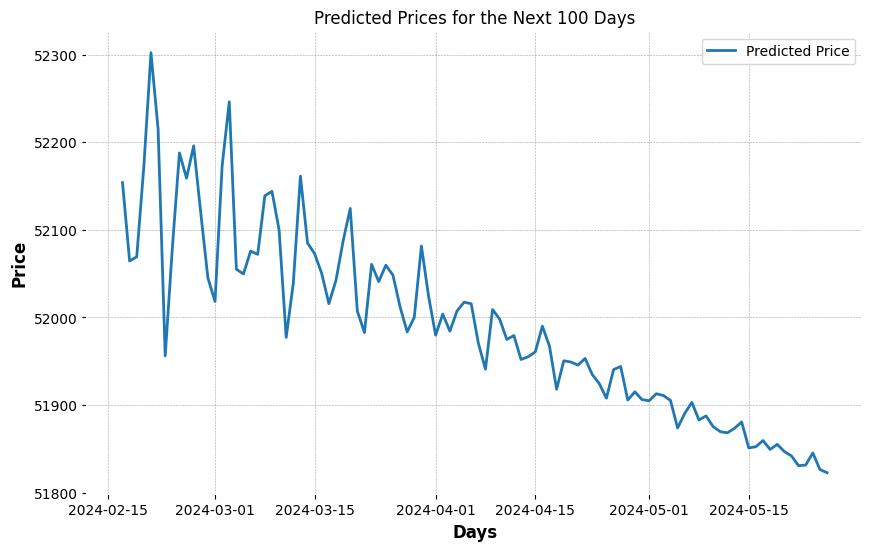

In [16]:
import matplotlib.pyplot as plt
# Assuming you have a fitted forecasting model and you want to make predictions for the next 100 days
next_day_price = fitted.forecast(100)

# Plot the predicted prices
plt.figure(figsize=(10, 6))
plt.plot(next_day_price, label='Predicted Price')
plt.title('Predicted Prices for the Next 100 Days')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
def get_stock_data(ticker, start_date, end_date):
    """
    Fetch historical stock data using YFinance.
    """
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

def get_company_info(ticker):
    """
    Fetch fundamental details of the company using YFinance.
    """
    company_info = yf.Ticker(ticker).info
    return company_info

def analyze_stock(stock_data):
    """
    Perform basic analysis on the stock data.
    """
    # Example: Calculate moving average
    stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()
    stock_data['MA200'] = stock_data['Close'].rolling(window=200).mean()
    return stock_data

def generate_investment_call(ticker):
    """
    Generate investment call based on analysis.
    """
    stock_data = get_stock_data(ticker, datetime.datetime.now() - datetime.timedelta(days=365), datetime.datetime.now())
    company_info = get_company_info(ticker)
    analyzed_data = analyze_stock(stock_data)

    # Example: Check if the current price is above 50-day and 200-day moving averages
    if analyzed_data['Close'][-1] > analyzed_data['MA50'][-1] and analyzed_data['Close'][-1] > analyzed_data['MA200'][-1]:
        return f"BUY recommendation for {ticker}. Current Price: {analyzed_data['Close'][-1]}, 50-Day MA: {analyzed_data['MA50'][-1]}, 200-Day MA: {analyzed_data['MA200'][-1]}. Company Profile: {company_info}"
    else:
        return f"HOLD recommendation for {ticker}. Current Price: {analyzed_data['Close'][-1]}, 50-Day MA: {analyzed_data['MA50'][-1]}, 200-Day MA: {analyzed_data['MA200'][-1]}. Company Profile: {company_info}"

In [24]:
# Example usage:
ticker = 'BTC-USD'  # Ticker symbol
investment_call = generate_investment_call(ticker)
print(investment_call)

[*********************100%%**********************]  1 of 1 completed

BUY recommendation for BTC-USD. Current Price: 51587.23828125, 50-Day MA: 44251.128359375, 200-Day MA: 35451.75330078125. Company Profile: {'name': 'Bitcoin', 'startDate': 1278979200, 'description': 'Bitcoin (BTC) is a cryptocurrency launched in 2010. Users are able to generate BTC through the process of mining. Bitcoin has a current supply of 19,630,193. The last known price of Bitcoin is 51,738.46491643 USD and is down -0.36 over the last 24 hours. It is currently trading on 10819 active market(s) with $23,229,243,325.82 traded over the last 24 hours. More information can be found at https://bitcoin.org/.', 'maxAge': 86400, 'priceHint': 2, 'previousClose': 51661.97, 'open': 51661.97, 'dayLow': 51234.71, 'dayHigh': 51762.848, 'regularMarketPreviousClose': 51661.97, 'regularMarketOpen': 51661.97, 'regularMarketDayLow': 51234.71, 'regularMarketDayHigh': 51762.848, 'volume': 21460783104, 'regularMarketVolume': 21460783104, 'averageVolume': 24114495116, 'averageVolume10days': 29826800455,